### Installing essential libraries

In [ ]:
# Perform Google Colab installs
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.


## 1. Document Processing and Text Embedding

### Collecting Data

In [ ]:

# Download the Data
import requests

# Get PDF document
pdf_path = "PG-REGULATION-CORRECTED_pdf.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF to download
  url = "https://klyuniv.ac.in/wp-content/uploads/2022/01/PG-REGULATION-CORRECTED_pdf.pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File PG-REGULATION-CORRECTED_pdf.pdf exists.


In [ ]:
import fitz
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 0,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': 0,
  'page_char_count': 2157,
  'page_word_count': 377,
  'page_sentence_count_raw': 9,
  'page_token_count': 539.25,
  'text': '1    REGULATIONS FOR MASTER’S PROGRAMME OF THE UNIVERSITY OF KALYANI  1. GENERAL  Notwithstanding anything contained anywhere in the Regulation and Rules (otherwise decided  by the Executive Council), it  is  hereby  provided  that   the   Master’s Programme in the Faculty  of Science (Biophysics, Biochemistry, Botany, Chemistry, Environmental Science, Geography,  Mathematics, Microbiology, Molecular Biology & Biotechnology, Physics, Physiology,  Sericulture, Statistics, Zoology, Ecological Studies), Master’s Programme in the Faculty of Arts  & Commerce (Bengali, English, Hindi, History, Folklore, Sanskrit, Political Science,  Philosophy, Economics, Sociology, Commerce, Library and Information Science, Rural  Development Studies), Master’s Programme in the Faculty of Education (Education, Physical  Education/ Fine Arts) (Semester System)  wil

In [ ]:
from spacy.lang.en import English

nlp = English()

nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [ ]:
%%time
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 77.7 ms, sys: 903 µs, total: 78.6 ms
Wall time: 94.6 ms


In [ ]:
import random
random.sample(pages_and_texts, k=1)

[{'page_number': 7,
  'page_char_count': 719,
  'page_word_count': 130,
  'page_sentence_count_raw': 2,
  'page_token_count': 179.75,
  'text': '8    7.2:   The Academic Calendar ratified by the Faculty Council (PG) will be announced by the  University Authority before commencement of new academic session and shall be strictly  followed for the duration of teaching, preparatory leave for students and examination and  publication of results.  7.3:   Without any contravention of the existing Act/Statute/Ordinance of the University, the  Vice- Chancellor of the University shall have the power to settle any issue which is not  covered under this regulation including the issue of awarding grace mark of maximum  one mark in the cases where a candidate has failed due to shortage of one marks/ has  failed to secure 50%, 55% and 60% due to shortage of one mark.',
  'sentences': ['8    7.2:   The Academic Calendar ratified by the Faculty Council (PG) will be announced by the  University Authorit

In [ ]:
%%time
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 14.7 ms, sys: 7 µs, total: 14.7 ms
Wall time: 15 ms


In [ ]:
random.sample(pages_and_texts, k=1)

[{'page_number': 4,
  'page_char_count': 2639,
  'page_word_count': 490,
  'page_sentence_count_raw': 14,
  'page_token_count': 659.75,
  'text': '5    I, II, III, IV, V and VI supplementary examination will be held in the next year with  semester regular examination. If he/she fails to clear the paper(s) in the first  supplementary examination, he/she will appear next supplementary examination in the  next year with the regular examinations. For semester VII & VIII, supplementary  examination will be held in the next year with regular examinations of the concerned  semester. If he/she again fails to clear the paper(s) in the next year, a special  supplementary examination will be held within three-weeks of the declaration of  supplementary results. But for semester IX & X, supplementary examination will be held  within 3 weeks of the declaration of results and if a student again fails to clear the  paper(s) in the  supplementary examination, he/ she will appear in a special  supplemen

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/8 [00:00<?, ?it/s]

13

In [ ]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 5,
  'sentence_chunk': '6  required to apply to the Controller of Examinations, through the Chairperson of the concerned PGBOS, for enrollment as a casual / supplementary candidate within 15 working days from the publication of the results.  6. REVIEW AND SCRUTINY 6.1:  There shall be re-evaluation (review) of the answer scripts of theoretical papers of semester end examinations but not of Internal Assessment marks. However, for re- evaluation, the candidate has to apply through the concerned Head of the Department, in a prescribed format, to the Controller of Examinations. Re-evaluation shall be permitted not more than two theoretical papers for any semester end examinations in the 2 year Master’s Programme or not more than 50% of the theoretical papers for any semester end examinations in 5 year Integrated Master’s Programme, on submission of prescribed fees within 15 working days from the publication of result of concerned semester. No application for revaluation of

In [ ]:
# Get stats about our chunks
import pandas as pd
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,13.00,13.00,13.00,13.00
mean,3.31,1197.00,207.00,299.25
std,2.10,489.62,93.34,122.41
min,0.00,561.00,91.00,140.25
25%,2.00,757.00,124.00,189.25
50%,3.00,1251.00,212.00,312.75
75%,5.00,1542.00,268.00,385.50
max,7.00,2102.00,383.00,525.50


In [ ]:
min_token_length = 30
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': 0,
  'sentence_chunk': '1  REGULATIONS FOR MASTER’S PROGRAMME OF THE UNIVERSITY OF KALYANI 1. GENERAL Notwithstanding anything contained anywhere in the Regulation and Rules (otherwise decided by the Executive Council), it is hereby provided that  the  Master’s Programme in the Faculty of Science (Biophysics, Biochemistry, Botany, Chemistry, Environmental Science, Geography, Mathematics, Microbiology, Molecular Biology & Biotechnology, Physics, Physiology, Sericulture, Statistics, Zoology, Ecological Studies), Master’s Programme in the Faculty of Arts & Commerce (Bengali, English, Hindi, History, Folklore, Sanskrit, Political Science, Philosophy, Economics, Sociology, Commerce, Library and Information Science, Rural Development Studies), Master’s Programme in the Faculty of Education (Education, Physical Education/ Fine Arts) (Semester System) will be held according to the following regulations. The Kalyani University Executive Council makes this Regulation in exercise

### Embedding text chunks

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Requires !pip install sentence-transformers
from sentence_transformers import util, SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447464e-02 -4.51087253e-03 -4.98483423e-03  6.55444637e-02
 -9.87672526e-03  2.72835493e-02  3.66425887e-02 -3.30221560e-03
  8.50079302e-03  8.24952498e-03 -2.28497107e-02  4.02430221e-02
 -5.75200096e-02  6.33692443e-02  4.43207808e-02 -4.49507460e-02
  1.25284223e-02 -2.52012070e-02 -3.55292521e-02  1.29558714e-02
  8.67023412e-03 -1.92917697e-02  3.55632859e-03  1.89506132e-02
 -1.47128226e-02 -9.39843804e-03  7.64168892e-03  9.62190144e-03
 -5.98927913e-03 -3.90169360e-02 -5.47824726e-02 -5.67456894e-03
  1.11645199e-02  4.08067591e-02  1.76319077e-06  9.15297028e-03
 -8.77261441e-03  2.39382703e-02 -2.32784320e-02  8.04999545e-02
  3.19176726e-02  5.12595009e-03 -1.47708422e-02 -1.62524804e-02
 -6.03213236e-02 -4.35689576e-02  4.51211669e-02 -1.79053992e-02
  2.63367146e-02 -3.47867012e-02 -8.89172684e-03 -5.47674969e-02
 -1.24372719e-02 -2.38606632e-02  8.33496824e-02  5.71242534e-02
  1.13328667e-02 -1.49594946e-02  9.2037

In [ ]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/13 [00:00<?, ?it/s]

CPU times: user 409 ms, sys: 9.37 ms, total: 418 ms
Wall time: 773 ms


In [ ]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [ ]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 264 ms, sys: 4.69 ms, total: 269 ms
Wall time: 317 ms


tensor([[ 0.0173, -0.0407,  0.0006,  ..., -0.0031, -0.0411, -0.0095],
        [-0.0002, -0.0721,  0.0003,  ..., -0.0339, -0.0477, -0.0376],
        [-0.0347, -0.0548, -0.0053,  ...,  0.0148, -0.0569, -0.0150],
        ...,
        [ 0.0049, -0.0252,  0.0069,  ...,  0.0040, -0.1017, -0.0366],
        [-0.0142, -0.0456,  0.0038,  ..., -0.0507, -0.0682, -0.0190],
        [ 0.0247, -0.0572, -0.0090,  ...,  0.0013, -0.0180, -0.0271]],
       device='cuda:0')

In [ ]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [ ]:
import numpy as np
# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([13, 768])

In [ ]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,1 REGULATIONS FOR MASTER’S PROGRAMME OF THE U...,2102,322,525.50,"[0.0173083171, -0.0407027975, 0.000568372197, ..."
1,1,2 a) Candidates with Undergraduate Degree ...,1251,212,312.75,"[-0.000202328854, -0.0720931962, 0.00029691073..."
2,1,3. ATTENDANCE 3.1: A student is required to ...,879,146,219.75,"[-0.0347092487, -0.0547777265, -0.00526617328,..."
3,2,3 4. EXAMINATION & EVALUATION 4.1: The evalu...,1360,222,340.00,"[0.0386505872, -0.0686265901, -0.0109680016, -..."
4,2,e) Moderated question papers will be handed ov...,724,124,181.00,"[0.0256363302, -0.0632321015, 0.0118553741, 0...."


### Embedding the query

In [ ]:

# 1. Define the query
query = "Attendance"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: Attendance
Time take to get scores on 13 embeddings: 0.00824 seconds.


torch.return_types.topk(
values=tensor([0.4461, 0.3379, 0.2693, 0.2483, 0.2398], device='cuda:0'),
indices=tensor([ 2, 12,  7,  5,  0], device='cuda:0'))

In [ ]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

## 2. RAG - Search and Answer

In [ ]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Attendance'

Results:
Score: 0.4461
Text:
3. ATTENDANCE 3.1:   A student is required to attend all classes. Attendance in
Theory and Practical classes  shall be counted separately as per UGC guideline.
3.2:   A candidate shall be allowed to appear at any of the semester
examinations if he/she has attended 75% or above of the programme
lectures/practical classes held during that semester. If the attendance falls
short of 75%, he/she shall not be allowed to appear in the examination. He/she
shall be allowed to take re-admission in corresponding semester, only in the
next year as provided in clause no.5.1(b) & 5.1(c).  Candidate having the
attendance below 75% but above 60% may be considered for appearing in the
semester examination subject to approval of the appeal of the concerned student
with the medical certificate or any other relevant documents, by the Central
Committee constituted by the Vice Chancellor.
Page number: 1


Score: 0.3379
Text:
8  7.2:  The Academic Calendar ra

In [ ]:

# 1. Define the query
query = "Attendance"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the cosine similarity
from time import perf_counter as timer

start_time = timer()
cosine_similarity = util.cos_sim(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(cosine_similarity, k=5)
top_results_dot_product

Query: Attendance
Time take to get scores on 13 embeddings: 0.00143 seconds.


torch.return_types.topk(
values=tensor([0.4461, 0.3379, 0.2693, 0.2483, 0.2398], device='cuda:0'),
indices=tensor([ 2, 12,  7,  5,  0], device='cuda:0'))

### Similarity Search

In [ ]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Attendance'

Results:
Score: 0.4461
Text:
3. ATTENDANCE 3.1:   A student is required to attend all classes. Attendance in
Theory and Practical classes  shall be counted separately as per UGC guideline.
3.2:   A candidate shall be allowed to appear at any of the semester
examinations if he/she has attended 75% or above of the programme
lectures/practical classes held during that semester. If the attendance falls
short of 75%, he/she shall not be allowed to appear in the examination. He/she
shall be allowed to take re-admission in corresponding semester, only in the
next year as provided in clause no.5.1(b) & 5.1(c).  Candidate having the
attendance below 75% but above 60% may be considered for appearing in the
semester examination subject to approval of the appeal of the concerned student
with the medical certificate or any other relevant documents, by the Central
Committee constituted by the Vice Chancellor.
Page number: 1


Score: 0.3379
Text:
8  7.2:  The Academic Calendar ra

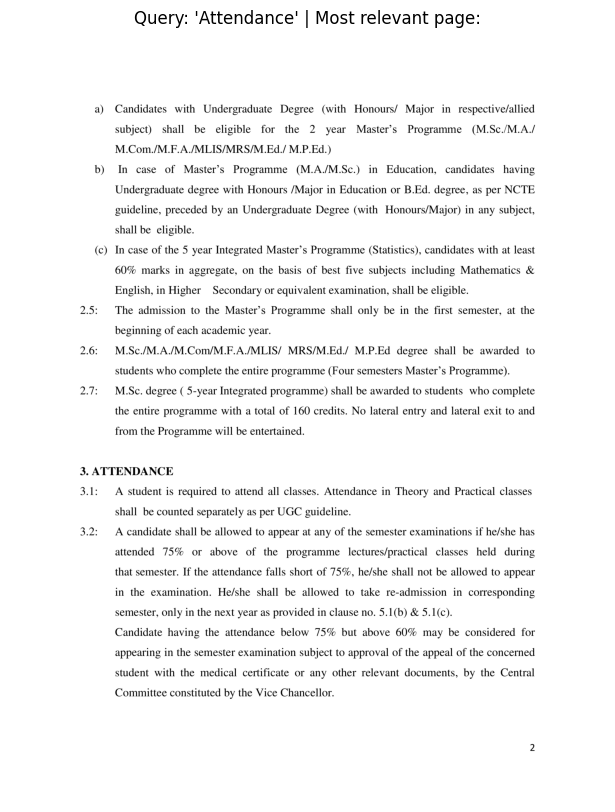

In [ ]:
import fitz

# Open PDF and load target page
pdf_path = "/content/PG-REGULATION-CORRECTED_pdf.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(1) # number of page

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [ ]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [ ]:
query = "Evaluation Scheme"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 13 embeddings: 0.00009 seconds.


(tensor([0.4730, 0.3767, 0.3689, 0.3383, 0.3312], device='cuda:0'),
 tensor([ 3,  9,  4, 11,  5], device='cuda:0'))

In [ ]:
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 13 embeddings: 0.00009 seconds.
Query: Evaluation Scheme

Results:
Score: 0.4730
3  4. EXAMINATION & EVALUATION 4.1:  The evaluation scheme for each course shall
contain two parts:  a) Semester end examination  and  (b) Internal Assessment
The weightage given to semester end examination and the internal assessment
shall be 80: 20 should be highlighted in the Course/Syllabus outline of each
Department. Each Department shall formulate its own method of Internal
Assessment, which shall be communicated to the students at the beginning of the
Course. 4.2: The paper setters, examiners, scrutinizers, reviewers and members
of the Board of Moderator for each semester will be appointed by the Controller
of Examinations on the recommendation of the respective Post Graduate Board of
Studies (PG-BOS) as per University Statute.   a)  Moderation of question papers
will be done by the Board of Moderators (consisting of internal and at least one
external moderator). C

In [ ]:
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [ ]:
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.


In [ ]:
!git config --global credential.helper 'store --file ~/.my-credentials'

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Your token has been saved in your con

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading.
# For models that require 4-bit quantization (use this if low GPU memory is available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
llm_model


GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [ ]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012344832, 'model_mem_mb': 4780.14, 'model_mem_gb': 4.67}

In [ ]:
input_text = "What is the evaluation scheme?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What is the evaluation scheme?

Prompt (formatted):
<bos><start_of_turn>user
What is the evaluation scheme?<end_of_turn>
<start_of_turn>model



In [ ]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    603,    573,  13167,
          12360, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    603,    573,  13167,
         12360, 235336,    107,    108,    106,   2516,    108,    688,  36678,
         12360,    688,    603,    476,  31554,   2185,   1671,    577,   7535,
           578,   8363,    573,  10617,    577,    948,    476,   5913,    689,
          3542,  21798,    573,  10626,  12830,    689,  17122, 235265,   1165,
         57175,    573,  12830,    578,   5358,   1671,    577,  18739,    573,
          1160, 235269,    578,   6572,    476,   3110,   8377,    576,   1212,
           603,   5043, 235265,    109,    688,   2469,   6635,    576,    671,
         13167,  12360,  6605

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What is the evaluation scheme?

Output text:
**Evaluation scheme** is a systematic process used to assess and determine the extent to which a student or project meets the specified criteria or objectives. It outlines the criteria and methods used to evaluate the work, and provides a clear understanding of what is expected.

**Key elements of an evaluation scheme:**

* **Objectives:** Clear and specific learning goals or standards that the work is assessed against.
* **Criteria:** Specific characteristics or qualities that will be assessed to determine if the objectives are met.
* **Methods:** The specific techniques or tools used to evaluate the work, such as tests, essays, presentations, or peer reviews.
* **Weighting:** The relative importance assigned to each criterion or method.
* **Scoring:** The process of assigning a numerical or categorical value to the work based on its performance against the criteria.
* **Feedback:** A clear and constructive description of the st

In [ ]:

query_list = [
    "What are the two parts included in the evaluation scheme for each course?",
    "How is the weightage distributed between semester end examination and internal assessment?",
    "Who appoints paper setters, examiners, scrutinizers, reviewers, and members of the Board of Moderators for each semester?",
    "What is the process of moderation of question papers?",
    "Who evaluates the theoretical answer scripts of semester end examinations?",
    "What is the duration of examination for theoretical papers depending on their marks?",
    "How long is the duration for practical examinations based on their marks?",
    "How is the transparency of the evaluation process ensured regarding internal assessment marks?",
    "Under what circumstances may a student be given a second chance for a missed class test during an ongoing semester?",
    "How many times can a student who has failed in any semester examination reappear for the same examination?",
    "What is the minimum aggregate percentage required for a student to qualify in a semester examination?"
]

In [ ]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What are the two parts included in the evaluation scheme for each course?
[INFO] Time taken to get scores on 13 embeddings: 0.00007 seconds.


(tensor([0.6950, 0.5669, 0.5639, 0.5397, 0.5203], device='cuda:0'),
 tensor([ 3, 11,  5,  9,  4], device='cuda:0'))

In [ ]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What is the purpose of having both semester end examinations and internal assessments in the evaluation scheme?
Answer: The purpose of having both semester end examinations and internal assessments is to provide a comprehensive evaluation of the students' knowledge and skills. Semester end examinations test the understanding of the entire course content, while internal assessments focus on continuous evaluation, including class participation, assignments, projects, and quizzes.

\nExample 2:
Query: How are paper setters, examiners, and moderators appointed for semester examinations?
Answer: Paper setters, examiners, and moderators are appointed by the Controller of Examinations based on recommendations from the respective Post Graduate Board of Studies (PG-BOS). The Chairperson of the PG-BOS serves as the Chairman of the Board of Moderators, ensuring a fair and balanced evaluation process.

\nExample 3:
Query: Can you explain the moderation process for question papers?
Answer: The moderation process involves a Board of Moderators, comprising both internal and at least one external moderator. They review and refine the question papers to ensure clarity, fairness, and alignment with the course objectives. Once moderated, the question papers are handed over to the Controller of Examinations for printing, preservation, and distribution.

\nExample 4:
Query: What measures are in place to ensure transparency in the evaluation process?
Answer: Transparency in the evaluation process is ensured through various measures. Internal assessment marks are published and displayed on the department notice board at least one week before semester end examinations. Additionally, students have the opportunity to appeal for retests or review their internal assessment answer scripts.

\nExample 5:
Query: How many times can a student reappear for a semester examination if they fail initially?
Answer: A student who fails in any semester examination may reappear for the same examination only twice in the subsequent period. This policy allows students the opportunity to improve their performance while maintaining academic standards and progression.

\nExample 6:
Query: What is the minimum passing criteria for a semester examination?
Answer: To qualify in a semester examination, a student must obtain a minimum aggregate of 40% marks (equivalent to grade D and above on the grade point scale) in each paper. This criterion ensures that students demonstrate a satisfactory level of understanding and proficiency in the course material.

\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: How is the transparency of the evaluation process ensured regarding internal assessment marks?
[INFO] Time taken to get scores on 13 embeddings: 0.00007 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What is the purpose of having both semester end examinations and internal assessments in the evaluation scheme?
Answer: The purpose of having both semester end examinations and internal assessments is to provide a comprehensive evaluation of the students' knowledge and skills. Semester end examinations test the understanding of the entire course content, while internal assessments focus on continuous evaluation, including class participation

In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True,
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: How is the transparency of the evaluation process ensured regarding internal assessment marks?
RAG answer:
<bos>The passage says that the internal assessment marks awarded to the students in each programme in a semester shall be published and put up on the notice board of the Department, at least one week before the commencement of semester end examination. This ensures transparency and allows the students to be aware of their performance before they take the examination.<eos>
CPU times: user 3.09 s, sys: 0 ns, total: 3.09 s
Wall time: 3.19 s


In [ ]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: Under what circumstances may a student be given a second chance for a missed class test during an ongoing semester?
[INFO] Time taken to get scores on 13 embeddings: 0.00007 seconds.
Answer:

According to the context, a student may be given a second chance for a missed
class test during an ongoing semester if he/she makes an appeal to the
Chairperson of the PGBOS. The student must justify his/her absence by providing
an authentic certified document.
Context items:


[{'page_number': 3,
  'sentence_chunk': '4  4.4:  To ensure transparency of the evaluation process, the Internal assessment marks awarded to the  students in each programme in a semester shall be published and put up on the notice board of the Department, at least one week before the commencement of semester end examination. 4.5:  In case, internal assessment is conducted by class tests, there shall generally be no retest if a student misses such a class test during an ongoing semester. He/she may be given a second chance only with the permission of the Departmental Committee, provided he/she makes an appeal to the Chairperson of the PGBOS. The student has to justify his/her absence by providing an authentic certified document. 4.6:  A student cannot be allowed to consider his/her appeal for internal assessment second time. Internal Assessment answer scripts (in case of class tests) shall be shown to the students concerned. 4.7: Students who have failed in any semester examination may 